In [1]:
import numpy as np
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation, metrics

C:\Users\leoli\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\leoli\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn import cross_validation
from sklearn.externals import joblib
from scipy.stats.stats import pearsonr
import sys
import os
from sklearn.utils import shuffle ###replace=False
from sklearn.metrics import mean_squared_error

In [3]:
lowerbound = 2
totaldis = 50
res1 = 25000
resn1 = '25kb'
celltype1 = 'Gm12878'

In [4]:
def geninput(lb, td, res, resn, celltype1,celltype2, chrnum, ep=True, peak=False):
    chromhmmcount = np.genfromtxt('/Users/leoli/Desktop/ChromHMM/'+celltype1+'_'+chrnum+'_'+resn+'_18marks_chromhmm.countmat')
    epcount = chromhmmcount[:,0]+chromhmmcount[:,8]+chromhmmcount[:,9]
    if ep==True:
        epindex = np.where(epcount>0)[0]
    else:
        epindex = np.where(epcount==0)[0]
    #np.save('/Users/leoli/Desktop/ChromHMM/'+celltype1+'_'+chrnum+'_'+resn+'_18marks_chromhmm.epindex', epindex)
    if peak==False:
        chipinput = np.load('/Users/leoli/Desktop/divided_mean_'+celltype1+'_'+chrnum+'_epi_'+resn+'.npy')
    else:
        histoneinput = np.load('/Users/leoli/Desktop/'+celltype1+'_'+chrnum+'_HistoneonPeaks_'+resn+'.npy')
        TFinput = np.load('/Users/leoli/Desktop/'+celltype1+'_'+chrnum+'_TFonPeaks_'+resn+'.npy')
        chipinput = np.column_stack((histoneinput,TFinput))
    hicinput = np.load('/Users/leoli/Desktop/'+celltype2+'.'+resn+'.'+chrnum+'.matrix.npy')
    genomicinput = np.load('/Users/leoli/Desktop/'+resn+'_'+chrnum+'.genomic.npy')
    featinput = np.column_stack((chipinput,genomicinput))

    if np.shape(hicinput)[0] != np.shape(chipinput)[0]:
        print 'HiC matrix has different row number with feature matrix'
    m,n=np.indices(hicinput.shape)
    ncol = np.shape(featinput)[1]
    outmat = np.empty((0,1+2*ncol+1), int)
    for i in range(lb,td):
        hic = hicinput[m==n-i]/np.mean(hicinput[m==n-i])
        epindex1 = epindex[epindex<(np.shape(hicinput)[0]-i)]
        epindex2 = epindex - i
        epindex2 = epindex2[epindex2>=0]
        ind = np.intersect1d(epindex1, epindex2)
        hicfinal = hic[ind]
        loc1 = np.take(featinput,ind, axis=0)
        loc2 = np.take(featinput,ind+i, axis=0)
        if np.shape(hicfinal)[0] != np.shape(loc1)[0]:
            print 'problem'
        dis = np.array([i]*len(hicfinal))
        sampleATdis = np.column_stack((hicfinal,loc1+loc2,abs(loc1-loc2),dis))
        outmat = np.append(outmat, sampleATdis,axis = 0)
    return (outmat[:,0], outmat[:,1::])

In [5]:
def genhic(lb, td, res, resn, celltype1,celltype2, chrnum, ep=True):
    chromhmmcount = np.genfromtxt('/Users/leoli/Desktop/ChromHMM/'+celltype1+'_'+chrnum+'_'+resn+'_18marks_chromhmm.countmat')
    epcount = chromhmmcount[:,0]+chromhmmcount[:,8]+chromhmmcount[:,9]
    if ep==True:
        epindex = np.where(epcount>0)[0]
    else:
        epindex = np.where(epcount==0)[0]
    hicinput = np.load('/Users/leoli/Desktop/'+celltype2+'.'+resn+'.'+chrnum+'.matrix.npy')
    m,n=np.indices(hicinput.shape)
    hicall = np.array([])
    for i in range(lb,td):
        hic = hicinput[m==n-i]#/np.mean(hicinput[m==n-i])
        epindex1 = epindex[epindex<(np.shape(hicinput)[0]-i)]
        epindex2 = epindex - i
        epindex2 = epindex2[epindex2>=0]
        ind = np.intersect1d(epindex1, epindex2)
        hicfinal = hic[ind]
        hicall = np.append(hicall,hicfinal)
    return hicall

In [6]:
labelsTrain, featuresTrain = geninput(lowerbound, totaldis, res1, resn1, celltype1, 'Gm12878_replicate', 'chr1', ep=True, peak=False)

In [7]:
labelsTest, featuresTest = geninput(lowerbound, totaldis, res1, resn1, celltype1, 'Gm12878_replicate', 'chr18', ep=True, peak=False)

In [9]:
labelsTrain2, featuresTrain2 = geninput(lowerbound, totaldis, res1, resn1, celltype1, 'Gm12878_replicate', 'chr1', ep=False, peak=False)

In [10]:
labelsTest2, featuresTest2 = geninput(lowerbound, totaldis, res1, resn1, celltype1, 'Gm12878_replicate', 'chr18', ep=False, peak=False)

In [10]:
primarylabel = genhic(lowerbound, totaldis, res1, resn1, 'Gm12878','Gm12878_primary', 'chr18', ep=True)

In [11]:
k562label = genhic(lowerbound, totaldis, res1, resn1,'Gm12878','K562', 'chr18', ep=True)

In [12]:
wholegenwidepredlabel = genhic(lowerbound, totaldis, res1, resn1,'Gm12878','Gm12878_RFpred', 'chr18', ep=True)

In [13]:
k562label_noep = genhic(lowerbound, totaldis, res1, resn1,'Gm12878','K562', 'chr18', ep=False)

In [14]:
primarylabel_noep = genhic(lowerbound, totaldis, res1, resn1, 'Gm12878','Gm12878_primary', 'chr18', ep=False)

In [10]:
numoff = np.shape(featuresTrain)[1]
numoftree=200
model = RandomForestRegressor(n_estimators=numoftree, n_jobs=20, max_features=(numoff/3), min_samples_leaf = 3, oob_score="True")
model.fit(featuresTrain, labelsTrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=11L, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=20,
           oob_score='True', random_state=None, verbose=0,
           warm_start=False)

In [ ]:
numoff = np.shape(featuresTrain)[1]
param_test1 = {'n_estimators':range(10,50,10),'criterion':["mse","mae"]}
gsearch1 = GridSearchCV(estimator = RandomForestRegressor(max_features=(numoff/3) ,random_state=10), 
                       param_grid = param_test1,cv=5)
gsearch1.fit(featuresTrain, labelsTrain)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [11]:
model.oob_score_

0.27871952474076733

In [17]:
np.shape(labelsTrain)

(31953L,)

In [16]:
scores = cross_val_score(model, featuresTrain, labelsTrain)
scores.mean()

0.1527798178873567

In [12]:
numoff2 = np.shape(featuresTrain2)[1]
numoftree=200
model2 = RandomForestRegressor(n_estimators=numoftree, n_jobs=20, max_features=(numoff2/3), min_samples_leaf = 3, oob_score="True")
model2.fit(featuresTrain2, labelsTrain2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=11L, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=20,
           oob_score='True', random_state=None, verbose=0,
           warm_start=False)

In [13]:
model2.oob_score_

0.59767760233569378

In [18]:
scores = cross_val_score(model2, featuresTrain2, labelsTrain2)
scores.mean()

0.52105326660701612

In [17]:
predictedtrainLabels = model.predict(featuresTrain)
print 'mse of training '+str(numoftree),mean_squared_error(labelsTrain,predictedtrainLabels)

mse of training 200 0.191613071942


In [18]:
predictedtestLabels = model.predict(featuresTest)
print 'mse of testing '+str(numoftree),mean_squared_error(labelsTest,predictedtestLabels)

mse of testing 200 0.829700450124


In [19]:
predictedtrainLabels2 = model2.predict(featuresTrain2)
print 'mse of training '+str(numoftree),mean_squared_error(labelsTrain2,predictedtrainLabels2)

mse of training 200 0.0803259616413


In [20]:
predictedtestLabels2 = model2.predict(featuresTest2)
print 'mse of testing '+str(numoftree),mean_squared_error(labelsTest2,predictedtestLabels2)

mse of testing 200 0.293622743201


In [21]:
def bydiscor (mat1,mat2,dis,lowerb, totald):
    pcor = [0]*totald
    scor = [0]*totald
    if np.shape(mat1) != np.shape(mat2):
        print "error, shapes are different!"
    for i in range(lowerb,totald):
        hic1 = mat1[np.where(dis==i)]
        hic2 = mat2[np.where(dis==i)]
        pcor[i] = pearsonr(hic1,hic2)[0]
        scor[i] = spearmanr(hic1,hic2)[0]
    return (pcor,scor)

In [22]:
p,s=bydiscor(predictedtestLabels,labelsTest, featuresTest[:,-1],lowerbound,totaldis)

In [23]:
p2,s2=bydiscor(primarylabel,labelsTest, featuresTest[:,-1],lowerbound,totaldis)

In [24]:
p3,s3=bydiscor(k562label,labelsTest, featuresTest[:,-1],lowerbound,totaldis)

In [25]:
p4,s4=bydiscor(predictedtestLabels2,labelsTest2, featuresTest2[:,-1],lowerbound,totaldis)

In [26]:
p5,s5=bydiscor(wholegenwidepredlabel,labelsTest, featuresTest[:,-1],lowerbound,totaldis)

In [27]:
p6,s6=bydiscor(k562label_noep,labelsTest2, featuresTest2[:,-1],lowerbound,totaldis)

In [28]:
p7,s7=bydiscor(primarylabel_noep,labelsTest2, featuresTest2[:,-1],lowerbound,totaldis)

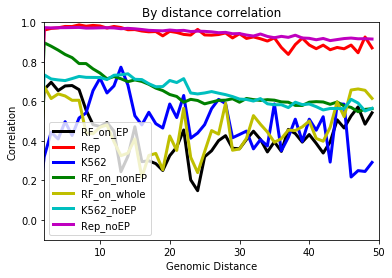

In [29]:
import matplotlib.pyplot as plt
# Plot
X = range(0, totaldis)
plt.plot(X, p, color='k', label='RF_on_EP',linewidth=3)
plt.plot(X, p2, color='r', label='Rep',linewidth=3)
plt.plot(X, p3, color='b', label='K562',linewidth=3)
plt.plot(X, p4, color='g', label='RF_on_nonEP',linewidth=3)
plt.plot(X, p5, color='y', label='RF_on_whole',linewidth=3)
plt.plot(X, p6, color='c', label='K562_noEP',linewidth=3)
plt.plot(X, p7, color='m', label='Rep_noEP',linewidth=3)
plt.title('By distance correlation')
plt.ylim(-0.1,1)
plt.xlim(2,50)
plt.xlabel('Genomic Distance')
plt.ylabel('Correlation')
plt.legend()
plt.show()

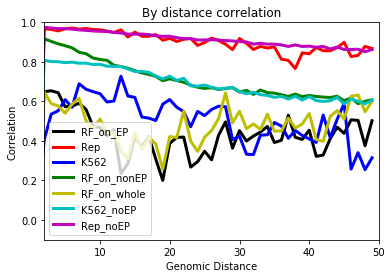

In [30]:
import matplotlib.pyplot as plt
# Plot
X = range(0, totaldis)
plt.plot(X, s, color='k', label='RF_on_EP',linewidth=3)
plt.plot(X, s2, color='r', label='Rep',linewidth=3)
plt.plot(X, s3, color='b', label='K562',linewidth=3)
plt.plot(X, s4, color='g', label='RF_on_nonEP',linewidth=3)
plt.plot(X, s5, color='y', label='RF_on_whole',linewidth=3)
plt.plot(X, s6, color='c', label='K562_noEP',linewidth=3)
plt.plot(X, s7, color='m', label='Rep_noEP',linewidth=3)
plt.title('By distance correlation')
plt.ylim(-0.1,1)
plt.xlim(2,50)
plt.xlabel('Genomic Distance')
plt.ylabel('Correlation')
plt.legend()
plt.show()

In [39]:
len(labelsTest2)

144110